In [ ]:
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [4]:
df = pd.read_csv('train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [5]:
df = df[df['label'].isin(['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet'])]

In [6]:
path = 'audio_train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 1500/1500 [06:51<00:00,  3.64it/s]
<ipython-input-6-930df66aaf4a>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  audio_data = np.array(audio_data)


In [10]:
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]
df.head()

,fname,label,manually_verified,audio_waves,samplerate,bit_lengths,seconds_length
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050,227556,10.32
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050,99666,4.52
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050,292824,13.28
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050,154350,7
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050,125685,5.7


In [11]:
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['samplerate']
df.head()

,fname,label,manually_verified,audio_waves,samplerate,bit_lengths,seconds_length
1,001ca53d.wav,Saxophone,1,"[-0.0007303721, -0.0010996412, -0.0010551845, ...",22050,227556,10.32
4,00353774.wav,Cello,1,"[-0.003822653, -0.0053708917, -0.0044372473, -...",22050,99666,4.52
5,003b91e8.wav,Cello,0,"[0.0031921505, 0.0048865937, 0.004513402, 0.00...",22050,292824,13.28
8,004ad66f.wav,Clarinet,0,"[-0.00018609133, -0.00029739283, -0.0003075322...",22050,154350,7
14,0091fc7f.wav,Cello,1,"[0.00042805163, 0.0005860274, 0.00045838652, 0...",22050,125685,5.7


In [21]:
#langkah ke 2

In [17]:
df = df[df['seconds_length'] >= 2.0]

In [16]:
min_bits = np.min(df['bit_lengths'])
print(min_bits)
min_seconds = np.min(df['seconds_length'])
print(min_seconds)

7056
0.32


In [18]:
with open('audio_df.pickle', 'wb') as f:
    pickle.dump(df, f)

In [19]:
with open('audio_df.pickle', 'rb') as f:
    df = pickle.load(f)

In [20]:
num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:11<00:00, 516.27it/s]


In [22]:
#langkah 3

In [23]:
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 6000/6000 [00:16<00:00, 363.19it/s]


In [24]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(6000, 7056)
(6000, 43, 13)


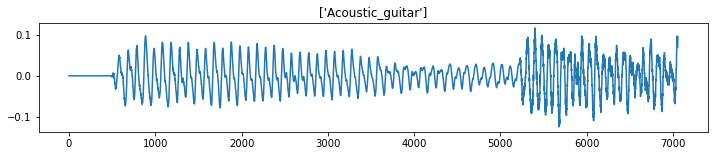

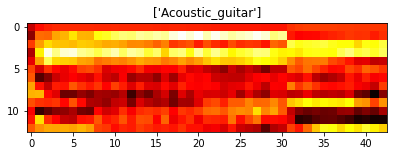

In [25]:
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[30])
plt.title(generated_audio_labels[30])
plt.show()
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[30].T, cmap='hot')
plt.title(generated_audio_labels[30])
plt.show()

In [26]:
#langkah 4

In [27]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)
print(label_encoded)

[3 4 3 ... 3 0 4]


C:\Users\Rama\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [31]:
label_encoded = label_encoded [:, np.newaxis] 
label_encoded

array([[3],
       [4],
       [3],
       ...,
       [3],
       [0],
       [4]])

In [32]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)
one_hot_encoded

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [33]:
#langkah 5

In [34]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [36]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4800, 43, 13, 1)
(1200, 43, 13, 1)


In [37]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same', input_shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['acc'])

In [38]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
150/150 [==============================] - 20s 30ms/step - loss: 1.5531 - acc: 0.2710 - val_loss: 1.2321 - val_acc: 0.4500
Epoch 2/30
150/150 [==============================] - 4s 24ms/step - loss: 1.2952 - acc: 0.4353 - val_loss: 1.1605 - val_acc: 0.5400
Epoch 3/30
150/150 [==============================] - 4s 24ms/step - loss: 1.1816 - acc: 0.5175 - val_loss: 1.0454 - val_acc: 0.5767
Epoch 4/30
150/150 [==============================] - 4s 26ms/step - loss: 1.0941 - acc: 0.5694 - val_loss: 0.9985 - val_acc: 0.6067
Epoch 5/30
150/150 [==============================] - 4s 25ms/step - loss: 1.0462 - acc: 0.5967 - val_loss: 0.9498 - val_acc: 0.6033
Epoch 6/30
150/150 [==============================] - 4s 26ms/step - loss: 0.9842 - acc: 0.6192 - val_loss: 0.9124 - val_acc: 0.6292
Epoch 7/30
150/150 [==============================] - 4s 27ms/step - loss: 0.9649 - acc: 0.6295 - val_loss: 0.8700 - val_acc: 0.6600oss: 0.9588  - ETA: 0s - loss: 0.9628 
Epoch 8/30
150/150 [==========

loss: 0.6749134063720703
val_loss: 0.6658230423927307


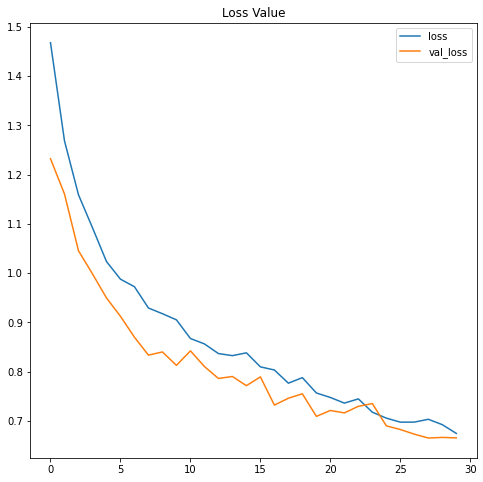

acc: 0.7387499809265137
val_acc: 0.7491666674613953


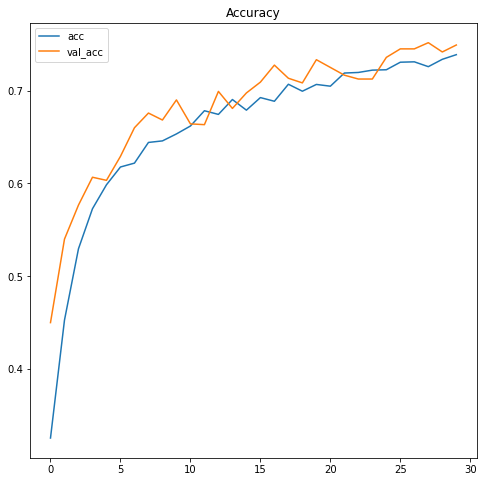

In [39]:
plt.figure (figsize = (8,8)) 
plt.title ('Loss Value') 
plt.plot (history.history ['loss']) 
plt.plot (history.history ['val_loss']) 
plt.legend (['loss', 'val_loss']) 
print ('loss:', history.history ['loss'] [- 1]) 
print ('val_loss:', history.history ['val_loss'] [- 1] ) 
plt.show ()
plt.figure (figsize = (8,8)) 
plt.title ('Accuracy') 
plt.plot (history.history ['acc']) 
plt.plot (history.history ['val_acc']) 
plt.legend ( ['acc', 'val_acc']) 
print ('acc:', history.history ['acc'] [- 1]) 
print ('val_acc:', history.history ['val_acc'] [- 1]) 
plt.show ()

In [40]:
#langkah 6

In [46]:
predictions = model.predict(X_test)

In [47]:
predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

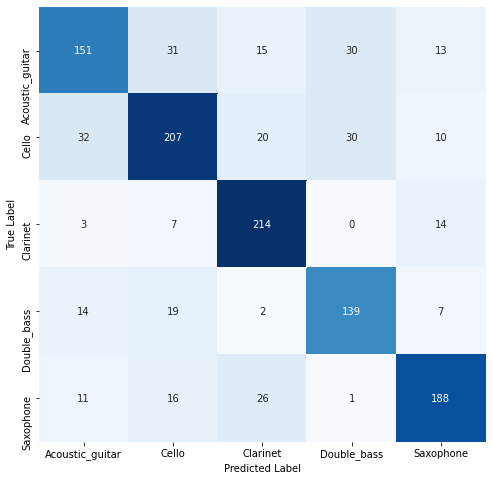

In [48]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()